In [0]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns

In [0]:
# Data overview
df = pd.read_csv ('Kaggle_Salary.csv')
df.head()

/Users/jasonzhang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,...,NaN,AWS Relational Database Service,NaN,NaN,NaN,NaN,NaN,-1,6,"60,000-69,999"


Part 1: Data Cleaning

From quick inspection of the dataset, there are 208 columns with missing values in the form of 'NaN', all of which are categorical data. The missing values exist for two reasons: the participant has chosen not to answer a certain question, or the participant has not chosen the given option of the question.  

Since some questions have its multiple choices presented in multiple features(columns), where the value of the column is NaN if the choice is not chosen, this can lead to columns with  many empty values. This means that even though a column has empty values, the column is not necessarily insignificant to the data, since it represents an option some participants have chosen. To ensure its significance, a columns is determined to be removed entirely if more than 50% of its values are missing. If a column satisfies this criteria, it would indicate that the option the column represents is not selected by a majority of particiants, and therefore is not relatively representative compared to the other features. In addition, features describing "TEXT" are deleted since they only carry word-count information and whether user-text has been recorded. For the features remaining, the NaN values are repalced with the modal value of the feature. 

For nominal categorical data, One-hot-encoding is used to generate dummy binary variables, ensuring that the non-ordinal nature of the categories are maintained. For ordinal categorical data such as Q1 and Q6, the data is transformed with custom ordinal mapping to maintain its ordinal relationships. 

In [0]:
# Number of features with missing values
mis_col_list = df.columns[df.isna().any()].tolist()
print(len(mis_col_list), 'columns have missing values before feature deletion')

208 columns have missing values before feature deletion


In [0]:
df_clean = df

# Delete features if more than 50% of values are missing
threshold = len(df) * .5
df_clean.dropna(thresh = threshold, axis = 1, inplace = True)

# Delete features describing TEXT and Q10 and Q10_buckets which is already represented by Q10_Encoded
text = df_clean.filter(like='TEXT').columns.tolist()
df_clean.drop(text, axis=1, inplace=True)
df_clean.drop(['Q10', 'Q10_buckets'], axis=1, inplace=True)

print(len(df_clean.columns), 'columns remain after feature deletion')

# Replace NaN values with the mode of each column
for col in df_clean.columns:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    
df_clean.head()

26 columns remain after feature deletion


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q11,...,Q18_Part_1,Q19,Q20_Part_2,Q21_Part_1,Q22,Q23,Q24_Part_1,Q24_Part_2,Q28_Part_1,Q10_Encoded
0,510,22-24,Male,France,Master’s degree,Software Engineer,"1000-9,999 employees",0,I do not know,$0 (USD),...,Python,Python,Matplotlib,CPUs,Never,1-2 years,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn,3
1,423,40-44,Male,India,Professional degree,Software Engineer,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","> $100,000 ($USD)",...,Python,Python,Matplotlib,CPUs,Never,< 1 years,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn,0
2,391,40-44,Male,Australia,Master’s degree,Other,"> 10,000 employees",20+,I do not know,"$10,000-$99,999",...,Python,Python,Matplotlib,CPUs,Once,2-3 years,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn,14
3,392,22-24,Male,India,Bachelor’s degree,Other,0-49 employees,0,No (we do not use ML methods),$0 (USD),...,Python,Python,Matplotlib,CPUs,Never,< 1 years,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn,0
4,470,50-54,Male,France,Master’s degree,Data Scientist,0-49 employees,3-4,"We have well established ML methods (i.e., mod...","$10,000-$99,999",...,Python,Java,Matplotlib,CPUs,Never,10-15 years,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn,6


In [0]:
# Convert non-numeric categorical values into numeric

for col in df_clean.columns:
    
    # encode every column except for columns with values that are already in numeric form or already encoded
    if col == 'Q10_Encoded' or col == 'Time from Start to Finish (seconds)':
        pass
    
    # use ordinal mapping for Q1, Q6, Q11, and Q15 (oridnal values)
    elif col == 'Q1' :
        ord_map = {'18-21':18, '22-24':22, '25-29':25, '30-34':30, '35-39':35, '40-44':40, '45-49':45, '50-54':50, '55-59':55, '60-69':60, '70+':70}
        df_clean['Q1'] = df_clean['Q1'].map(ord_map)
    elif col =='Q6':
        ord_map = {'0-49 employees':0, '50-249 employees':50, '250-999 employees':250, '1000-9,999 employees': 1000, '> 10,000 employees':10000}
        df_clean['Q6'] = df_clean['Q6'].map(ord_map)
    elif col == 'Q11' :
        ord_map = {'$0 (USD)':0, '$1-$99':1, '$100-$999':100, '$1000-$9,999':1000, '$10,000-$99,999':10000, '> $100,000 ($USD)':100000}
        df_clean['Q11'] = df_clean['Q11'].map(ord_map)
    elif col == 'Q15' :
        ord_map = {'I have never written code':0, '< 1 years':1, '1-2 years':2,'3-5 years':3, '5-10 years':4,'10-20 years':5, '20+ years':6}
        df_clean['Q15'] = df_clean['Q15'].map(ord_map)
    elif col == 'Q22' :
        ord_map = {'Never':0, 'Once':1, '2-5 times':2, '6-24 times':6, '> 25 times':25}
        df_clean['Q22'] = df_clean['Q22'].map(ord_map)
    elif col == 'Q23' :
        ord_map = { '< 1 years':0, '1-2 years':1, '2-3 years':2, '3-4 years':3, '4-5 years':4, '5-10 years':5, '10-15 years':10, '20+ years':20}
        df_clean['Q23'] = df_clean['Q23'].map(ord_map)
                
    else:
    # create dummy variables for all other feature categories using one-hot encoding
        one_hot = pd.get_dummies(df_clean[col])
        # drop the column that has been encoded
        df_clean = df_clean.drop(col, axis = 1)
        # add the newly encoded columns to the df
        df_clean = pd.concat([df_clean, one_hot], axis = 1)

In [0]:
df_clean.head()

,Time from Start to Finish (seconds),Q1,Q6,Q11,Q15,Q22,Q23,Q10_Encoded,Female,Male,...,Other,Python,R,SQL,TypeScript,Matplotlib,CPUs,Linear or Logistic Regression,Decision Trees or Random Forests,Scikit-learn
0,510,22,1000,0,2,0,1,3,0,1,...,0,1,0,0,0,1,1,1,1,1
1,423,40,10000,100000,0,0,0,0,0,1,...,0,1,0,0,0,1,1,1,1,1
2,391,40,10000,10000,2,1,2,14,0,1,...,0,1,0,0,0,1,1,1,1,1
3,392,22,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,1,1,1,1
4,470,50,0,10000,6,0,10,6,0,1,...,0,0,0,0,0,1,1,1,1,1


Part 2: Exploratory Data Analysis

Three bar plots are produced to represent trends in the data. 

The age distribution of participants is produced in plot #1. It can be observed that the plot follows a gaussian distribution where the peak number of participants fall under the age category of 25-29. This indicates that the participant demographic is relatively younge, also suggesting the general age demographic of the data science industry. 

The distribution of company size is produced in plot #2. Worth noting is that the two most size categories are 0-49 and >10,000. This indicates that the two major hiring sources are start-ups as well as giant corporations. This is also likely a trend in the data science industry. 

The distribution of annual compensation is produced in plot #3. It can clearly be seen that a great majority of participants fall under the compensation category of 0-9,999. This likely suggests that a majority of participants take on part-time/contract work relating to data science, explaining the relatively low degree of compensation. 

A correlation plot is generated for the top 15 highest-correlated features in the data set after cleaning/encoding. The following features have the highest (positive) correlation with the feature Q10_Encoded (with corresponding correlation values):

- 'United States of America': 0.55
- Q15 (How long have you been writing code to analyze data (at work or at school)?): 0.41
- Q1 (Age): 0.36
- Q23 (For how many years have you used machine learning methods?): 0.32
- Q11 (Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?): 0.32
- 'We have well established ML methods (i.e., models in production for more than 2 years): 0.23
- '20+': 0.19

These features are expected to have a positive correlation with the annual compensation of the participant, since they directly reflect the skill set and/or experience of the participant. 

Text(0, 0.5, 'Number of Participants')

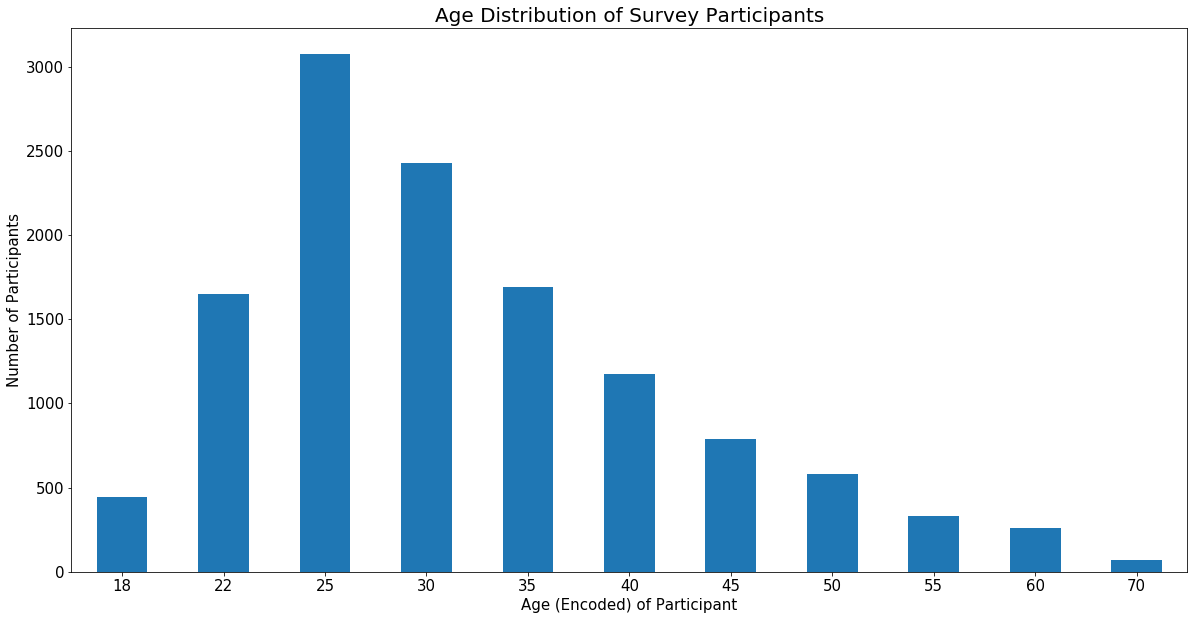

In [0]:
# Plot 1: Age distribution of Survey Participants
df_Q1 = df_clean.groupby(['Q1']).size()
ax1 = df_Q1.plot.bar(figsize = (20,10), fontsize=15, rot=0)
ax1.set_title('Age Distribution of Survey Participants', fontsize= 20)
ax1.set_xlabel("Age (Encoded) of Participant",fontsize=15)
ax1.set_ylabel("Number of Participants", fontsize=15)

Text(0, 0.5, 'Number of Participants')

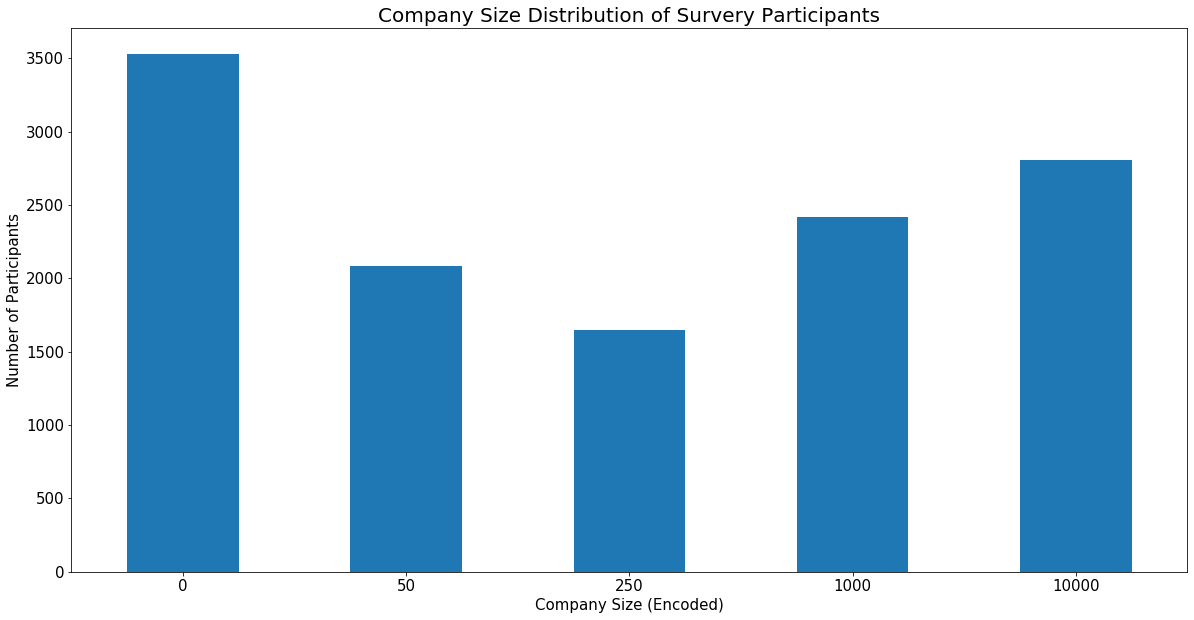

In [0]:
# Plot 2: Company size distribution of Survey Participants
df_Q6 = df_clean.groupby(['Q6']).size()
ax2 = df_Q6.plot.bar(figsize = (20,10), fontsize=15, rot=0)
ax2.set_title('Company Size Distribution of Survery Participants', fontsize= 20)
ax2.set_xlabel('Company Size (Encoded)', fontsize=15)
ax2.set_ylabel('Number of Participants', fontsize=15)

Text(0, 0.5, 'Number of Participants')

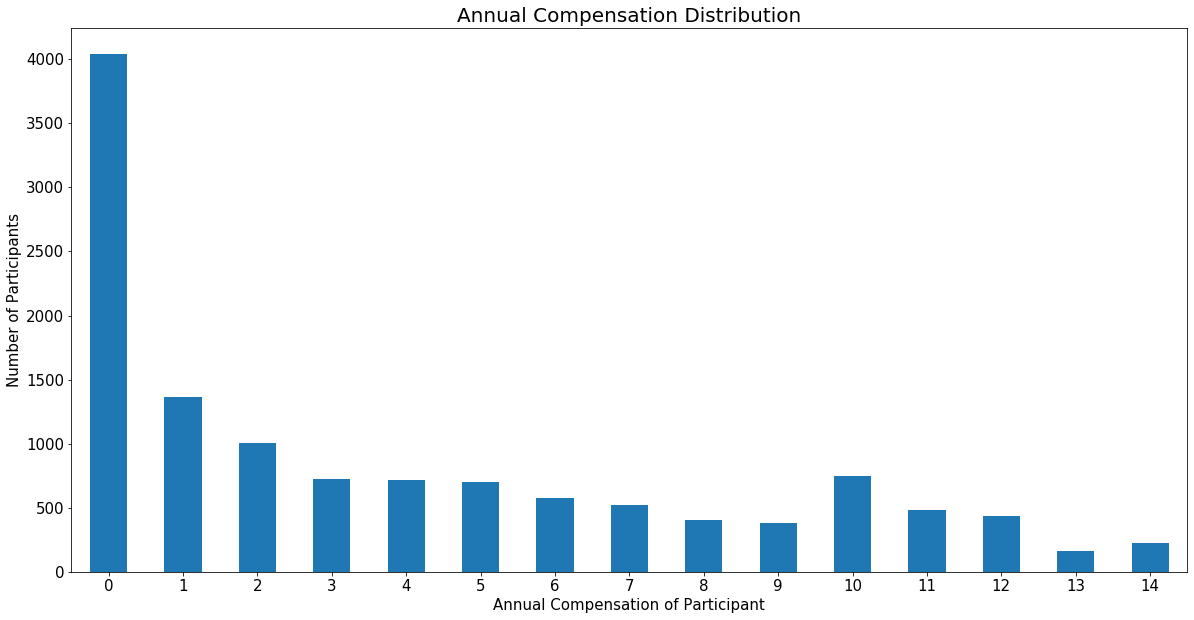

In [0]:
# Plot 3: Extent of Coding Experience of Survey Participants
df_Q10 = df_clean.groupby(['Q10_Encoded']).size()
ax3 = df_Q10.plot.bar(figsize = (20,10), fontsize=15, rot=0)
ax3.set_title('Annual Compensation Distribution', fontsize= 20)
ax3.set_xlabel('Annual Compensation of Participant',fontsize=15)
ax3.set_ylabel('Number of Participants', fontsize=15)

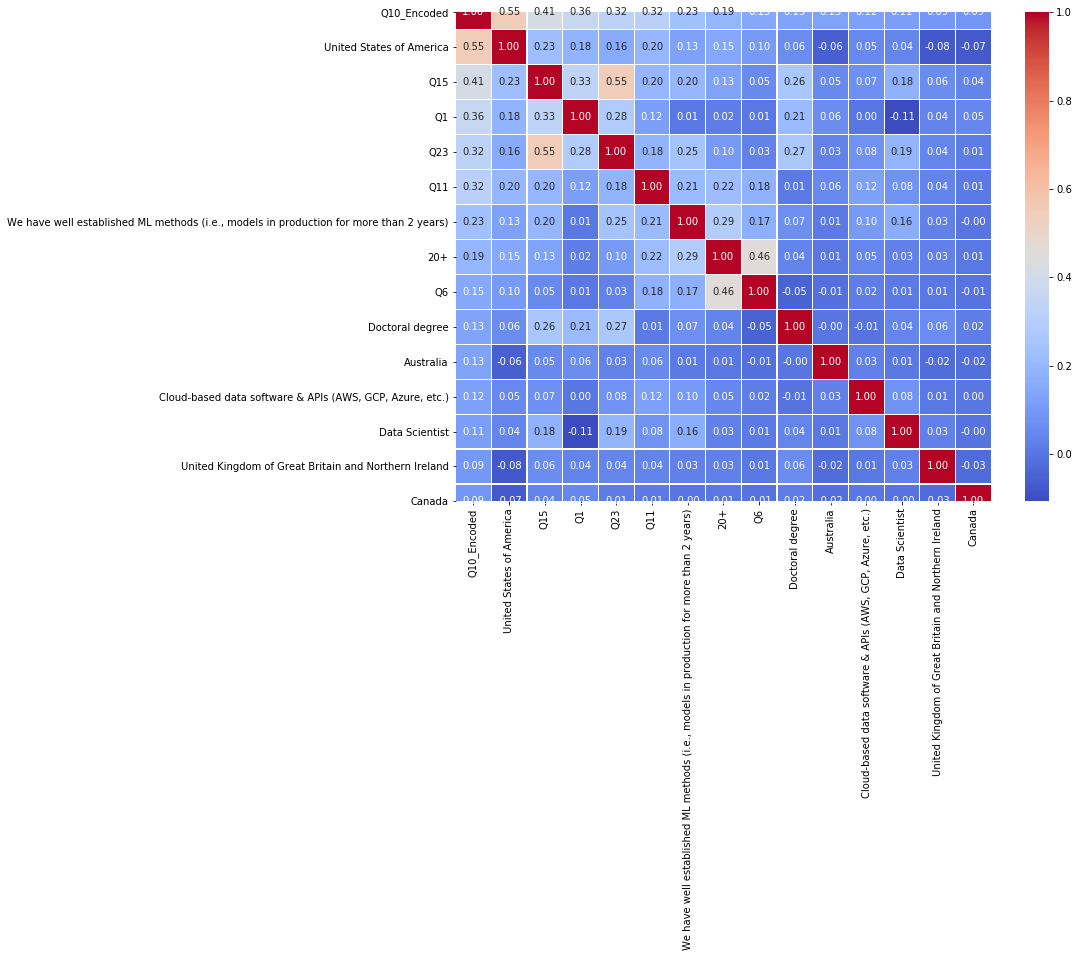

In [0]:
# Correlation Plot
# Plotting for the top 15 features most correlated with Q10_Encoded
k = 15
corrmat = df_clean.corr()  
cols = corrmat.nlargest(k, 'Q10_Encoded')['Q10_Encoded'].index 
  
cm = np.corrcoef(df_clean[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 9)) 
  
sn.heatmap(cm, ax = ax, cmap ="coolwarm", fmt='.2f', annot = True, linewidths = 0.1, yticklabels = cols.values, xticklabels = cols.values) 

Part 3: Feature Selection

Feature selection is important to reduce computational cost/time of training the model, as well as avoiding overfitting. In this section, the Extra Tree Classifier is used to perform feature selection based on feature importances. Extra Tree is considered to be the classifier with the lowest variance out of the other random tree classifiers, and therefore should perform well in reducing overfitting. The classifier generates a ranking based on the purity of the feature/node, and is presented in terms of feature importances. 

After computing and ranking the feature importance of each feature (as shown in the plot below), the top 50% of features ranked by importance are selected to carry forward. The 50% threshold should be a conservative measure to ensure that a significant portion of the features remain to be modelled in the next steps.

Note that since prior encoding has generated columns with duplicate names, these columns have been renamed for ease of selection. 

In [0]:
#renaming columns with duplicate names which can be problematic for feature selection
def uniquify(df_cols):
    seen = set()
    
    for item in df_cols:
        fudge = 1
        newitem = item

        while newitem in seen:
            fudge += 1
            newitem = "{}_{}".format(item, fudge)

        yield newitem
        seen.add(newitem)
    
df_clean.columns = list(uniquify(df_clean.columns))

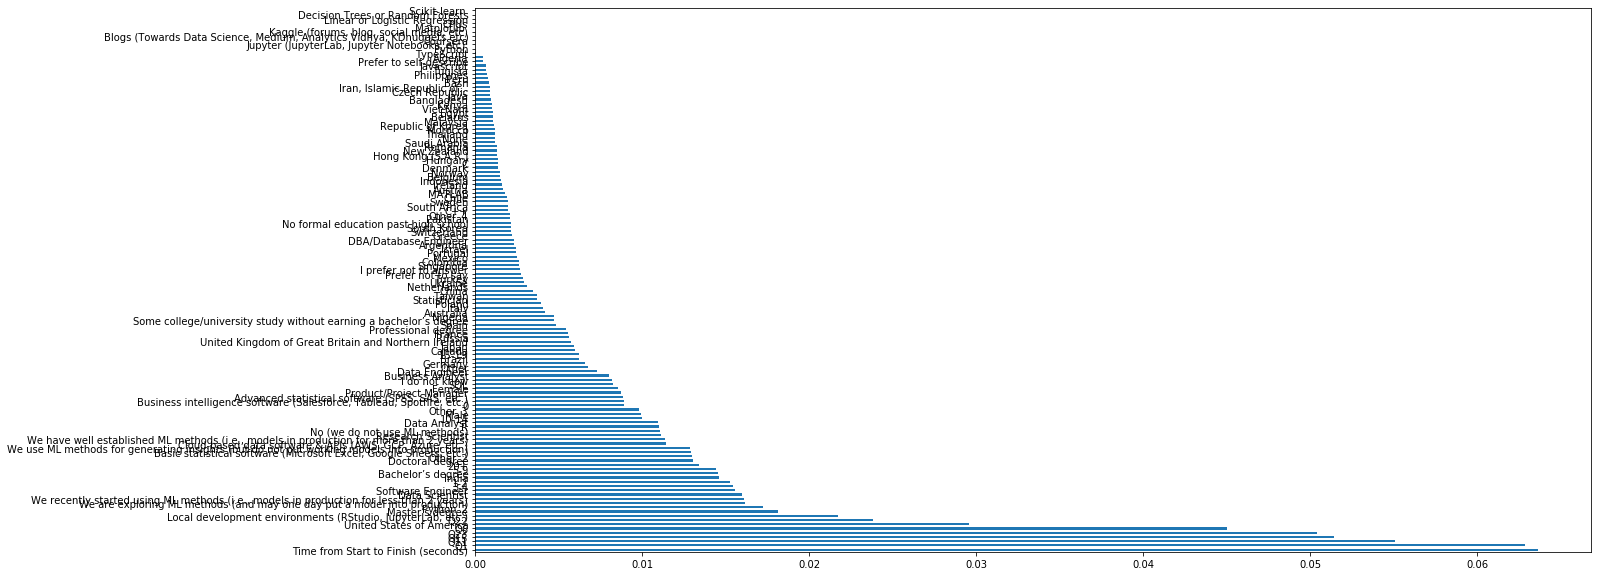

,Time from Start to Finish (seconds),Q1,Q11,Q15,Q23,Q6,United States of America,Q22,"Local development environments (RStudio, JupyterLab, etc.)",Master’s degree,...,Some college/university study without earning a bachelor’s degree,Nigeria,Australia,Italy,Poland,Statistician,Taiwan,China,Netherlands,Ukraine
0,510,22,0,2,1,1000,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,423,40,100000,0,0,10000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,391,40,10000,2,2,10000,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
3,392,22,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,470,50,10000,6,10,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# Separating target and feature columns
feature_cols = [col for col in df_clean.columns if col not in ['Q10_Encoded']]
X = df_clean[feature_cols]
y = df_clean['Q10_Encoded']
ETC = ExtraTreesClassifier()
ETC.fit(X,y)

#plot graph of feature importances
feat_imp = pd.Series(ETC.feature_importances_, index=X.columns)
#ranking and plotting feature importances of the 128 features
feat_ranked = feat_imp.nlargest(128)
feat_ranked.plot(kind='barh',figsize=(20,10))
plt.show()

#selecting top 50% (64) of features from feat_importances_ranked
feat_ranked_top = feat_ranked.iloc[0:64].index.tolist()
X_top = X[feat_ranked_top]
X_top.head()


Part 4: Model Implementation (Logistic Regression with 10-fold CV)

Using Logistic Regression with 10-fold cross-validation, the model accuracy for each fold are: 0.32, 0.35, 0.33, 0.34, 0.34, 0.36, 0.35, 0.37, 0.33, and 0.32.

The average and variance of the 10-fold accuracies are 0.34 (+/- 0.03).

For model hyperparamter tuning as well as the reason why a model performs best, please see part 5.

In [0]:
#modelling using logistic regression and cross validation
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=0)
clf = LogisticRegression(C=1).fit(X_train, y_train)
kfold = KFold(n_splits=10)
scores = cross_val_score(clf, X_train, y_train, cv=kfold)
#printing accuracy for each fold
for score in scores:
    print("Accuracy for each fold: %0.2f"% (score))

#printing accuracy for 10 folds
print("\nAverage and variance of accuracy for 10 folds: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2))

#probability data belonging to each of the of salary classes
probability = clf.predict_proba(X_train)
print('\nThe probability of each training data belonging to each of the of salary classes:\n', probability)

Accuracy for each fold: 0.32
Accuracy for each fold: 0.38
Accuracy for each fold: 0.33
Accuracy for each fold: 0.33
Accuracy for each fold: 0.34
Accuracy for each fold: 0.36
Accuracy for each fold: 0.33
Accuracy for each fold: 0.36
Accuracy for each fold: 0.34
Accuracy for each fold: 0.32

Average and variance of accuracy for 10 folds: 0.34 (+/- 0.03)

The probability of each training data belonging to each of the of salary classes:
 [[0.47277391 0.10553159 0.07810662 ... 0.00941487 0.00176904 0.00303206]
 [0.45497595 0.1346416  0.10671939 ... 0.00776282 0.00247315 0.00241005]
 [0.04802856 0.0721808  0.06646039 ... 0.13535102 0.02645377 0.00874265]
 ...
 [0.25533662 0.07490698 0.04925436 ... 0.03505104 0.02288709 0.02043494]
 [0.19280094 0.09340674 0.065493   ... 0.03053868 0.00527418 0.01909128]
 [0.18225233 0.07116395 0.0821259  ... 0.04965639 0.02049562 0.04517878]]


Part 5: Model Tuning and Comparison

Although cross validation helps with preventing the model from overfitting to the training data, regularization is also important in preventing overfitting. Too much regularization can cause the model to have too much bias error, and therefore underfit. Inversely, too little regularization can cause the variance error of the model to increase due to noise in the data, causing overfitting. This is why regularization as a hyperparameter needs to be tuned to find an ideal middle ground based on bias/variance trade-off. 

In this section, grid search is used to find the optimal hyperparamters for the logistic regression model in the previous section. The hyperparameters that need to determined are C and Penalty. Investigated are 10 C values equally spaced in log space from 0 to 100, and L1/L2 regularizations for penalty. From the grid search, we have found the best hyperparamters being: C = 2.78 and penalty = 'L1'. This gives us a new average accuracy of 0.36 (+/- 0.04), compared to 0.34 (+/- 0.03) in the previous model. 

In addition, another model using multinomial naive bayes is investigated, yielding an average accuracy of 0.23 (+/- 0.03) on the same sets of training data. This is significantly lower than that of the logistic regression model. This is likely due to the fact that NB assumes conditional independence of features in the data, which is not the case for many of the features (e.g. educational degree vs role title). 

In [0]:
#grid search of CV hyperparameter for logistic regressions
logreg = LogisticRegression()
#consider 10 values for C equally spaced in log space from 0 to 100
C = np.logspace(0,2, num=10)
#consider L1 and L2 regularization
penalty = ['l1', 'l2']

#grid search for optimal C and penalty values
#hyperparameters = dict(C=C, penalty=penalty)
#search = GridSearchCV(logreg, hyperparameters, cv=10)
#best_model = search.fit(X_train, y_train)

#print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Best C:', best_model.best_estimator_.get_params()['C'])

In [0]:
#logistic regression model performance with optimal parameters
clf = LogisticRegression(C=2.78, penalty='l1').fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=kfold)

print("Optimal Logistic Regression average and variance of accuracy for 10 folds: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2))

Optimal Logistic Regression average and variance of accuracy for 10 folds: 0.36 (+/- 0.04)


In [0]:
#multinomial Naive Bayes 
multiNB = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True).fit(X_train, y_train)
scores = cross_val_score(multiNB, X_train, y_train, cv=kfold)

print("Multinomial NB average and variance of accuracy for 10 folds: %0.2f (+/- %0.2f)" %(scores.mean(), scores.std() * 2))

Multinomial NB average and variance of accuracy for 10 folds: 0.23 (+/- 0.03)


Part 6: Test and Discussion

The test set accuracy of the optimal model is around 0.34. This is quite close to the training accuracy of 0.36. From the figure below, it can be seen that the distributions between training and testing predictions are very close, with the training prediction being slightly closer to that of the actual compensation. This indicates that the model is slightly overfit.

There are several ways to improve the train/test accuracies of the model:

1. Keep more features from being deleted during feature selection.
2. Incorporate feature scaling/normalization to ensure that features can be measured on the same scale, and that no feature dominates others based on its numeric values.
3. Check for more parameter values of C (10 checked in the optimal model).
4. Use other more complex models such as svm with kernels.

In [0]:
#test set accuracy
y_test_pred = cross_val_predict(clf, X_test, y_test, cv=10)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy: ", accuracy * 100, "%")

Test set accuracy:  34.586666666666666 %


Text(0, 0.5, 'Proportion')

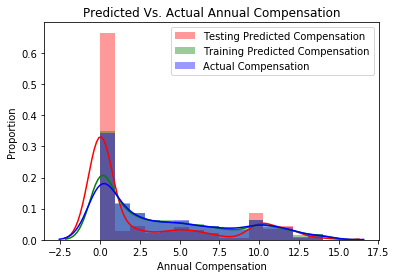

In [0]:
#plot histogram distributions for test and training predictions, as well as actual labels. 
sns.distplot(y_test_pred, bins=15, color='red', label='Testing Predicted Compensation')
sns.distplot(y_train, bins=15, color='green', label='Training Predicted Compensation')
ax=sns.distplot(y_test, bins=15, color='blue', label='Actual Compensation')
plt.legend()
ax.axes.set_title('Predicted Vs. Actual Annual Compensation')
ax.set_xlabel('Annual Compensation')
ax.set_ylabel('Proportion')